# Pneumonia Detection from X-rays using PyTorch 

## What is pneumonia?
Pneumonia is an infection that primarily causes inflammation in the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material) causing a combination of cough with phlegm, fever, chills, and difficulty in breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

## Why deep learning/machine learning for pneumonia diagnosis?
The primary tool for the initial diagnosis of pneumonia are x-ray images. Interpretation of x-ray images require expertise in radiology. Such an expertise becomes inaccessible when the demand doesn't meet the supply which became evident during the recent covid pandemic around the globe. 

Besides, access to expert medical care in remote areas and for backward socio-economic classes remains a big challenge. In the wake of covid-19 crisis, with rising deaths and limited medical resources, quick and accurate detection of pneumonia would increase the chance of survival. This is where automated methods to detect and classify human diseases from medical images become significant.

# The Data
The dataset used for this project is the "Chest X-Ray Images (Pneumonia)" from Kaggle. The dataset consists of training data, validation data, and testing data. The training data consists of 5,216 chest x-ray images with 1,341 normal images and 3,875 pneumonia images. The validation data is relatively small with only 16 images with 8 cases of pneumonia and 8 normal cases. The testing data consists of 624 images with 390 pneumonia cases and 234 normal cases.

# The Framework
We will be using the PyTorch deep learning framework to build the image classifier. PyTorch is a dynamic deep-learning framework which is easy to use as well. First we will do some exploratory data analysis(EDA), preprocess the data and then build a Convolutional Neural Network (CNN) for binary classification.






To begin with, import the required frameworks and libraries.

In [1]:
import os
import glob
import h5py
import shutil
import PIL
import imgaug as aug
import numpy as np # arrays
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

import torch
import torch.nn.functional as F #activation functions
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader #PyTorch data loading utility.
from torchvision.utils import make_grid
from torch.autograd import Variable



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
color = sns.color_palette()
%matplotlib inline



In [2]:
print('PyTorch version:', torch.__version__)

PyTorch version: 1.7.0+cu101


In [3]:
#Set random seed for reproducibility
torch.manual_seed(271828)
np.random.seed(271828)

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


 # Loading the Dataset 
 I have the Kaggle dataset uploaded in my google drive. Now let's define/name the paths to the images.

In [5]:
# Define path to the data directory
data_dir = Path('/content/gdrive/My Drive/kaggle/chest_xray')

#Path to train directory
train_dir = os.path.join(data_dir, 'train')

#Path to validation directory
val_dir = os.path.join(data_dir, 'val')

#Path to test directory
test_dir = os.path.join(data_dir, 'test')



# Data Preprocessing

The training directory has images classified into two folders: NORMAL and PNEUMONIA. The function `get_data()` does the preprocessing of the images dataset which includes:
- converting the categorical labels of 'Normal' and 'Pneumonia' to numerical - 0 and 1 respectively
- converting all  3-channel images to 1-channel (even though all the images are greyscale, the number of channels of many of them are three. It is important to make all the input images to have the same number of channels for feeding into the model).
- resizing images to a preffered size.
- returning a numpy array containing the preprocessed images and their respective numerical labels.


In [6]:
#Function to preprocess the data
labels = ['NORMAL', 'PNEUMONIA']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)#cv2.IMREAD_GRAYSCALE converts all 3-channel images to 1-channel
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
                #data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
#storing the train, validation, and test datasets as ndarrays
train = get_data(train_dir)
validation = get_data(val_dir)
test = get_data(test_dir)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
np.random.shuffle(train)

In [9]:
train.shape

(5216, 2)

# Exploratory Data Analysis
Let's begin by exploring the images in normal and pneumonia cases.

Number of normal images 1341
Number of pneumonia images 3875


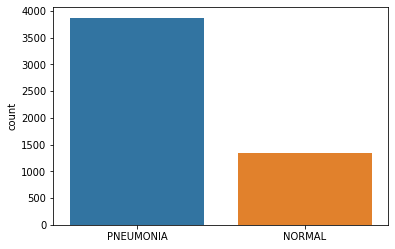

In [10]:
counts = []
for arrays in train:
  if arrays[1] == 0:
    counts.append("NORMAL")
  else:
    counts.append('PNEUMONIA')
print(f"Number of normal images {counts.count('NORMAL')}")
print(f"Number of pneumonia images {counts.count('PNEUMONIA')}")
sns.countplot(x = counts)


As can be seen from the above plot, the data is highly imbalanced. The number of pneumonia cases in the data is almost thrice that of the normal cases. This is a common occurence in case of certain domains such as medical data and financial fraud data. The main issue with such a class imbalance is an imbalanced sampling. In other words, while training, the model is more likely to draw a point from class_pneumonia than from class_normal here. Because the model sees much less of class_normal, it is less capable of learning useful features from such class. This needs to be corrected for by methods such as data augmentation of unders-sampled class or adding weights to equalize the probability of being chosen from each class.


Before getting into correcting the class imbalance, let's preview the first few images in the train set.


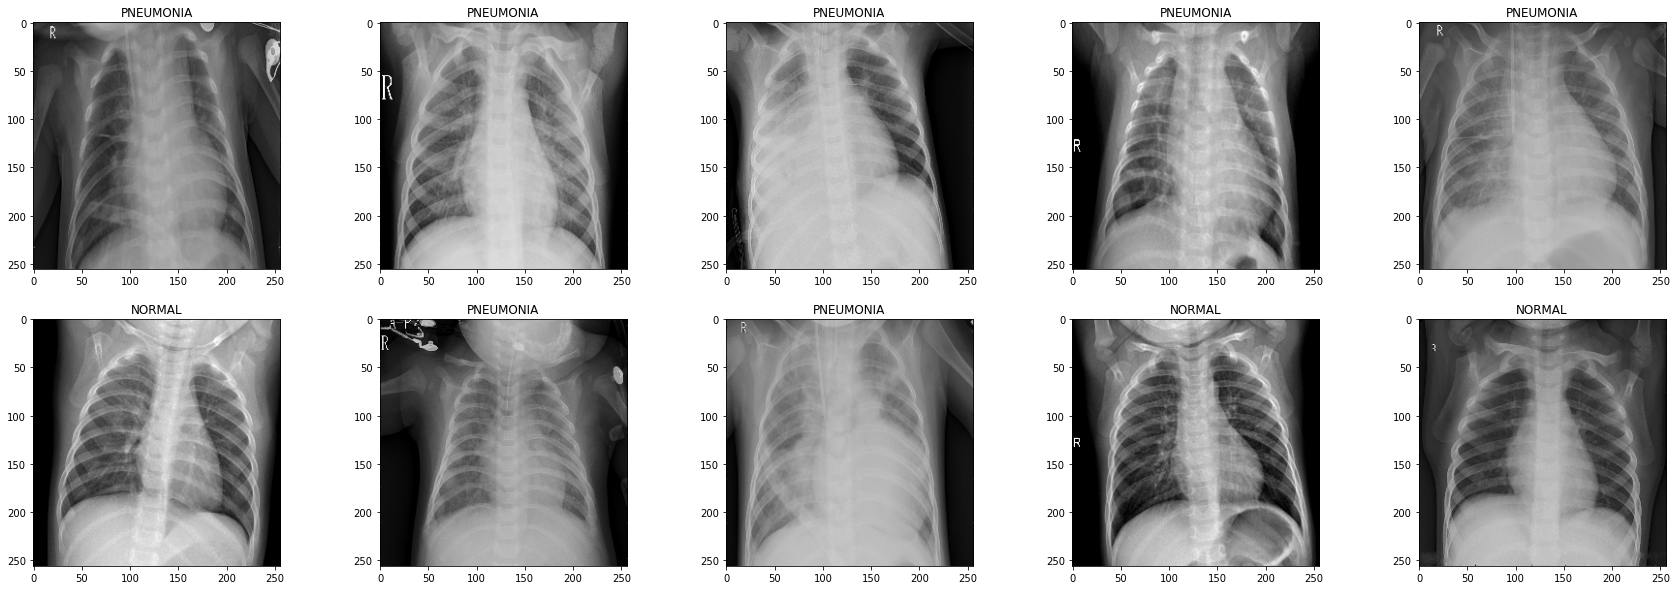

In [11]:
fig, axes = plt.subplots(2,5, figsize=(30,10))
for i in range(1, 11):
  plt.subplot(2,5,i)
  plt.imshow(train[i][0], cmap = 'gray')
  plt.title(labels[train[i][1]])


In [12]:
#Separating the features (images here) and labels into separate numpy arrays.
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in validation:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train)
y_train = np.array(y_train) 
x_val = np.array(x_val) 
y_val = np.array(y_val) 

x_test = np.array(x_test) 
y_test = np.array(y_test) 

In [13]:
x_train.shape

(5216, 256, 256)

# Preprocessing again..
## Normalization of the image data
We know images are comprised of matrices of pixel values. Gray images are a single matrix of pixels, whereas color images have a separate array of pixel values for each color channel of red, green, and blue. Pixel values are often unsigned integers in the range between 0 and 255. Although these pixel values can be input directly to neural network models in their raw format, this can result in slower training of models. A simple scaling of pixel values to the range 0 - 1,or centering and standardization of the values can be highly beneficial. It helps to keep activations of the networks and consequently their weights small during forward propagation thus reducing computational requirements. This helps the network to converge faster. In this project, we will be using a simple scaling of pixel values to 0 - 1 range.

 

In [14]:
print('Train', x_train.shape, y_train.shape)
print('Test', (x_test.shape, y_test.shape))
# summarize pixel values
print('Train:', x_train.min(), x_train.max(), x_train.mean(), x_train.std())
print('Validation:', x_val.min(), x_val.max(), x_val.mean(), x_val.std())
print('Test:', x_test.min(), x_test.max(), x_test.mean(), x_test.std())

Train (5216, 256, 256) (5216,)
Test ((624, 256, 256), (624,))
Train: 0 255 122.88935391888296 60.52028409382146
Validation: 0 255 124.82826519012451 65.33494705977114
Test: 0 255 120.94909403874324 60.463258022417726


We have confirmed above that pixel values are integer values between 0 and 255 and that the mean and standard deviation of the pixel values are similar between the two datasets. So we divide by 255 for normalization. 

In [15]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


A 2D convolutional neural network model (nn.Conv2d) in PyTorch needs a 4D tensor as input with the 4 dimensions being: [batch_size, channels, height, width]. So, we first resize the arrays to 4D and then convert them to torch tensors.

In [16]:
#Resizing the array for deep learning

# resize data for deep learning 
x_train = x_train.reshape(-1, 1, img_size, img_size)
x_val = x_val.reshape(-1, 1, img_size, img_size)
x_test = x_test.reshape(-1, 1, img_size, img_size)


In [17]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5216, 1, 256, 256)
(16, 1, 256, 256)
(624, 1, 256, 256)


Whenever the batch of images are initialized, it is on the CPU for computation by default. The function `torch.cuda.is_available()` will check whether a GPU is present. If CUDA is present, `.device("cuda")` will route the tensor to the GPU for computation.

In [18]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Correction for Class Imbalance using Weighted Random Sampling

Now, we can go on to corrrecting for the class imbalance in the training data using WeightedRandomSampling class in pytorch. Then the numpy arrays are converted to torch tensors and using the DataLoader class I convert torch tensors to dataloaders for using pytorch neural networks class. (Note that here I have used the DataLoader class of pytorch. However, PyTorch allows creation of one's own DataLoader class with required data transforms if need be).

In [19]:
batch_size = 15
class_sample_count = np.unique(y_train, return_counts=True)[1] #no. of samples in each class.
weight = 1. / class_sample_count
samples_weight = weight[y_train]#same as samples_weight = np.array([weight[t] for t in y_train])
                                #calculates the weight for each sample
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight,len(samples_weight))

trainDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train.astype(int)))
validDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val.astype(int)))
testDataset = torch.utils.data.TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test.astype(int)))


trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size = batch_size, num_workers=3, sampler = sampler)
validLoader = torch.utils.data.DataLoader(dataset = validDataset, batch_size = batch_size, shuffle=False, num_workers=3) 
testLoader = torch.utils.data.DataLoader(dataset = testDataset, batch_size = batch_size, shuffle=False, num_workers=3) 



In [20]:
for data, target in trainLoader:
  print (data.size())
  break

torch.Size([15, 1, 256, 256])


# Building and training the classifier
Now that the data is ready, it's time to build and train the classifier. For starters, let's start with an 8 layer 2D Convolutional Neural Network model with ReLU activation and MaxPooling.

A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery.They have applications in image and video recognition, recommender systems, image classification, medical image analysis and so on.

Convolutional networks were inspired by the connectivity pattern between neurons in the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The entire visual imagery is covered by different neurons together. Based on this connectivity pattern, the CNNs are not fully connected like linear layers. However, we add fully connected layers at the end of the architecture to take the results of the convolution/pooling process and use them to classify the image into a label.

CNNs use relatively little pre-processing compared to other image classification algorithms. CNNs are trained to identify and extract the best features from the images that in traditional algorithms were hand-engineered. This independence from prior knowledge and human effort in feature design is a major advantage.

<br>

# Structure of a Convolutional Neural Network

<br>

![](https://drive.google.com/uc?export=view&id=1Zd_fypURVnipv36eDv8yAghPUJPf7sKK)

Image Source: https://www.researchgate.net/publication/321203105_Identifying_Single_Trial_Event-Related_Potentials_in_an_Earphone-Based_Auditory_Brain-Computer_Interface



# Different Layers of the CNN 

## Convolution Layer

Central to the CNN is the convolutional layer that gives the network its name. This layer performs an operation called a “convolution", i.e. the process of applying filters to an input to create feature maps summarizing the various features present in the input. The speciality of CNN is that these filters are learned during the training process for a particular prediction problem.

In CNNs, a convolution is a linear operation that involves the multiplication of a set of weights with the input. For 2D image data, the multiplication is performed between an array of input data and a two-dimensional array of weights, called a filter or a kernel.

A filter smaller than the input is used as the systematic application of the same filter across the entire input image gives the opportunity to discover specific features. The output for the same feature differs for different positions, a property known as equivariance to translation. The two-dimensional output array that is generated by repeated multiplication of the filter with the input array is called the “feature map".

## Activation Layer - Rectified Linear Unit (ReLU)

Activation function decides, whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron. Without an activation function, a neural network is essentially just a linear regression model. The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks.

In this project, we use ReLU activation function given by $A(x) = max(0,x)$. 

## Pooling layer

A limitation of the feature map output of convolutional layers is that they depend on the precise position of features in the input. That is, different positions of the feature in the input image results in different feature maps. This can happen with re-cropping, rotation, shifting, and other minor changes to the input image.

A common approach to address this issue is **down sampling** where a lower resolution version of the input signal with the important structural elements intact but without the fine details that may not be useful to the task is created. This is done adding a pooling layer after the non-linearity has been applied on the feature maps.

In this project we use the maximum pooling (or max pooling) where the maximum value for each patch of the feature map is chosen resulting in a summarized version of the features detected in the input. Pooling helps to make the representation become approximately invariant to small translations of the input.






In [21]:
class CNNModel_8(nn.Module):   
    def __init__(self):
        super(CNNModel_8, self).__init__()

        self.network = nn.Sequential(
            # Defining a 2D convolution layers
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(262144, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = CNNModel_8().to(device)


Let's define the other hyperparameters of the model including the optimizer, the learning rate, and the loss function. Here we are using a cross entropy loss function and the Adam optimizer.

In [23]:
# Hyper parameters
num_epochs = 10
num_classes = 2
learning_rate = 0.0001

#defining the optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate )

#defining the loss function
criterion = nn.CrossEntropyLoss()

In [24]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

Now that the architecture of the model is ready, we will write a script to train the model.

In [25]:
def model_train_validation():

  %%time

  #lists to keep track of losses
  epoch_train_loss = []
  epoch_valid_loss = []

  for epoch in range(1, num_epochs + 1):
    #track training and validation losses
    running_train_loss = 0.0
    running_valid_loss = 0.0

    #sets the module in training mode So effectively layers like dropout, batchnorm etc. which behave different on the train and 
    #test procedures behave accordingly (specified in SOURCE CODE FOR TORCH.NN.MODULES.MODULE)
    model.train()
    for data, target in trainLoader:
      #move tensors to GPU
      data = data.to(device)
      target = target.to(device)

      # clear-the-gradients-of-all-optimized-variables - In PyTorch, we need to set the gradients to zero before starting to do backpropragation because 
      #PyTorch accumulates the gradients on subsequent backward passes
      optimizer.zero_grad()

      #forward-pass: compute predicted outputs by passing inputs to the model
      output = model(data)

      #calculate the loss for this batch
      loss = criterion(output, target)

      #backward pass: compute gradient of the loss wrt model parameters
      loss.backward()

      #optimization - parameter updation 
      optimizer.step()

      #update the training loss for th batch
      running_train_loss += loss.item() * data.size(0) #Note that in pytoch, the default reduction parameter in loss calculation is 'mean' implying the loss returned is divided by the batch size. So, must mutiply with data.size(0) to get the total loss in the batch.
    
    #Validating the model

    model.eval() #puts the pytorch model in eval() mode

    for data, target in validLoader:
      data = data.to(device)
      target = target.to(device)

      output = model(data)
      
      loss = criterion(output, target)

      #update the validation loss for the batch
      running_valid_loss += loss.item() * data.size(0)

    #Calculate the epoch losses

    running_train_loss = running_train_loss / len(trainLoader.sampler)
    running_valid_loss = running_valid_loss / len(validLoader.sampler)
    epoch_train_loss.append(running_train_loss)
    epoch_valid_loss.append(running_valid_loss)

    #print-training/validation-statistics

    print(f"Epoch: {epoch} \t Training loss: {running_train_loss:0.6f} \t Validation loss: {running_valid_loss}") 


In [ ]:
model_train_validation()#training the model

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Epoch: 1 	 Training loss: 0.319177 	 Validation loss: 0.4538644168060273
Epoch: 2 	 Training loss: 0.117500 	 Validation loss: 0.26037029980216175
Epoch: 3 	 Training loss: 0.068213 	 Validation loss: 0.045423189492794336
Epoch: 4 	 Training loss: 0.055845 	 Validation loss: 0.01947468725120416
Epoch: 5 	 Training loss: 0.045219 	 Validation loss: 0.06187533063348383
Epoch: 6 	 Training loss: 0.033492 	 Validation loss: 0.029967651469597456
Epoch: 7 	 Training loss: 0.039780 	 Validation loss: 0.02012850873188654
Epoch: 8 	 Training loss: 0.026455 	 Validation loss: 0.07381230724854504
Epoch: 9 	 Training loss: 0.020313 	 Validation loss: 0.18202675614520558
Epoch: 10 	 Training loss: 0.013061 	 Validation loss: 0.029000515351071954


In [26]:
#test the model
def accuracy_func(data_loader, dataset):
  model.eval()#model in the evaluation phase, disables dropout
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0) #total number of training examples in the batch
      correct += (predicted == labels).sum().item() #sum of examples where predictions match the label
    
    print(f"Accuracy of the model for {dataset} is {100 * correct/total}")
  
  #Save the model for future inference
  torch.save(model.state_dict(), "model.ckpt")

In [ ]:
accuracy_func(validLoader, 'validation dataset')

Accuracy of the model for validation dataset is 100.0


In [ ]:
accuracy_func(testLoader, "test dataset")

Accuracy of the model for test dataset is 79.00641025641026


We get a model accuracy of 79% for test data and 100% for the validation data. This is really good considering we yet have to introduce batch normalization (to standardize the inputs to a layer for each mini-batch) and dropout to account for overfitting. So deepening the network with 13 CNN layers and adding batch normalization and dropout to see if the model accuracy improves.

In [27]:
#CNN Model 13 layers with Batch Normalization and Dropout
class CNNModel_13(nn.Module):
    def __init__(self):
        super(CNNModel_13, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(512*256, 1024),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2, bias=True))
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
#Changing the model to CNNModel_13
model = CNNModel_13().to(device)
print(model)


CNNModel_13(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [29]:
#Changing the learning rate and redifining the optimizer with the new learning rate, and new model parameters
learning_rate = 0.0001 #0.0001
num_epochs = 10       #25
optimizer = optim.Adam(model.parameters(), lr = learning_rate )
#defining the loss function
criterion = nn.CrossEntropyLoss()
  

In [30]:
model_train_validation()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs
Epoch: 1 	 Training loss: 0.483375 	 Validation loss: 6.1565962433815
Epoch: 2 	 Training loss: 0.164368 	 Validation loss: 0.41823489125818014
Epoch: 3 	 Training loss: 0.138311 	 Validation loss: 0.2084977726917714
Epoch: 4 	 Training loss: 0.096070 	 Validation loss: 0.17860023537650704
Epoch: 5 	 Training loss: 0.096266 	 Validation loss: 0.2615390304126777
Epoch: 6 	 Training loss: 0.086276 	 Validation loss: 0.4755443874746561
Epoch: 7 	 Training loss: 0.057863 	 Validation loss: 1.2893781810862492
Epoch: 8 	 Training loss: 0.073008 	 Validation loss: 0.14608217123895884
Epoch: 9 	 Training loss: 0.050399 	 Validation loss: 1.116892099377651
Epoch: 10 	 Training loss: 0.056989 	 Validation loss: 0.5930307451635599


### Performance Metrics

In [31]:
accuracy_func(validLoader, 'validation dataset')

Accuracy of the model for validation dataset is 81.25


In [32]:
accuracy_func(testLoader, 'test dataset')

Accuracy of the model for test dataset is 87.33974358974359


We can see that with the above specified hyperparameters, the accuracy goes as high as 87.34% for the test data. Though not high enough to be used in real life applications, the accuracy of the model is significantly high.

Now, the next step would be apply transfer learning using pretrained models such as VGG16 to see how the model fairs.